### A machine learning model for predicting band gap of materials

Presented by: Ali Davari

I picked Crystal Graph Convolutional Network model based on [Crystal Graph Convolutional Neural Networks for an Accurate and Interpretable Prediction of Material Properties](https://doi.org/10.1103/PhysRevLett.120.145301) paper by [Tian Xie](https://github.com/txie-93) et al. 

In CGCNN, a crystal structure is represented as a graph where nodes correspond to atoms and edges represent atomic bonds or spatial relationships. This graph-based representation captures both local and global structural information of the crystal, which is crucial for predicting material properties. The unique feature of CGCNN is its ability to process varying input sizes and structures, as each crystal can have different numbers of atoms and types of bonding. The input features to a CGCNN typically include physical properties of the atoms, such as atomic number, atomic radius, and electronegativity, which provide essential information about the nature of the atoms and their interactions. Additionally, features can also include information about the bonding environment of each atom, like bond length. These features are then processed through convolutional layers that aggregate information from neighboring nodes (atoms) and edges (bonds), allowing the network to learn complex patterns in the material's structure, which are crucial for predicting various material properties.

![image](images/cgcnn.png)
Image [Ref.](https://doi.org/10.1103/PhysRevLett.120.145301)

### Installation

~~~sh
git clone https://github.com/adavaria/rewotes.git
cd adavaria
conda create -n cgcnn python=3 scikit-learn pytorch ipykernel torchvision pymatgen -c pytorch -c conda-forge -y
conda activate cgcnn
python setup.py install
~~~

### Input dataset preparation:

To prepare for defining a custom dataset, you'll need the following:

- **CIF files** detailing the structures of the crystals of interest.
- **Target properties** for each crystal. For prediction purposes, placeholder values in `id_prop.csv` are sufficient.

To create your custom dataset, set up a directory, `root_dir`, containing:

- `id_prop.csv`: A CSV file with two columns. The first column should have a unique ID for each crystal, and the second column should record the value of the target property. For use with `predict.py`, any number can be placed in the second column (it's required but can be arbitrary).

- **ID.cif**: CIF files that record the crystal structure, where `ID` corresponds to the unique ID for the crystal.

The structure of `root_dir` should be as follows:
~~~
root_dir/
├── id_prop.csv
├── atom_init.json
├── id0.cif
├── id1.cif
├── ...
~~~

#### Collecting data from MP:

~~~python
import mlband.data

print('Downloading the data from MP...' ,flush=True)
# each chunk is 1,000 data points
df, data = mlband.data.get_list_of_materials(num_chunks=1)
print('Creating the dataset...', flush=True)
data_set_path = 'data/mp-test/'
mlband.data.create_dataset(df=df, path=data_set_path)
~~~

### Featerizing the elements

Below you can see some of the available elemental features fed to the nodes through one-hot-encoding. [Magpie](https://github.com/ramv2/magpie_python) was used to collect these elemental properties. 

In [2]:
import mlband.features
mlband.features.pt

,symbol,atomic number,atomic mass,group,period,MeltingT,MiracleRadius,CovalentRadius,FirstIonizationEnergy,GSestFCClatcnt,...,GSenergy_pa,HeatCapacityMolar,n_ws^third,HeatFusion,ZungerPP-r_d,ZungerPP-r_pi,NpValence,Row,FusionEnthalpy,GSbandgap
0,H,1,1.007940,1,1,14.01,0.0,31.0,13.598443,2.979865,...,-3.331291,28.836,1.50,0.060,0.0,0.000,0.0,1.0,0.060,7.853
1,He,2,4.002602,18,1,0.00,0.0,28.0,24.587387,3.664774,...,0.001135,20.786,0.00,0.000,0.0,0.000,0.0,1.0,0.000,18.098
2,Li,3,6.941000,1,2,453.69,152.0,128.0,5.391719,4.048846,...,-1.869887,24.860,0.98,3.000,0.0,0.360,0.0,2.0,3.000,0.000
3,Be,4,9.012182,2,2,1560.00,112.0,96.0,9.322700,3.160184,...,-3.755039,16.443,1.67,7.895,0.0,0.200,0.0,2.0,7.895,0.000
4,B,5,10.811000,13,2,2348.00,88.0,84.0,8.298020,3.061330,...,-6.677698,11.087,1.75,50.200,0.0,0.165,1.0,2.0,50.200,1.524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,Fl,114,289.000000,14,7,0.00,0.0,0.0,0.000000,0.000000,...,0.000000,0.000,0.00,0.000,0.0,0.000,0.0,0.0,0.000,0.000
114,Mc,115,290.000000,15,7,0.00,0.0,0.0,0.000000,0.000000,...,0.000000,0.000,0.00,0.000,0.0,0.000,0.0,0.0,0.000,0.000
115,Lv,116,293.000000,16,7,0.00,0.0,0.0,0.000000,0.000000,...,0.000000,0.000,0.00,0.000,0.0,0.000,0.0,0.0,0.000,0.000
116,Ts,117,294.000000,17,7,0.00,0.0,0.0,0.000000,0.000000,...,0.000000,0.000,0.00,0.000,0.0,0.000,0.0,0.0,0.000,0.000


The selected properties when then will be one-hot-encoded to be used and the intial vector for each node.

In [4]:
# List of available features
print(mlband.features.get_available_features())

['atomic number', 'atomic mass', 'group', 'period', 'MeltingT', 'MiracleRadius', 'CovalentRadius', 'FirstIonizationEnergy', 'GSestFCClatcnt', 'Electronegativity', 'Density', 'ZungerPP-r_s', 'DipolePolarizability', 'GSestBCClatcnt', 'LogThermalConductivity', 'NsValence', 'GSmagmom', 'Polarizability', 'NValence', 'IsAlkali', 'AtomicVolume', 'phi', 'Number', 'IsNonmetal', 'NfValence', 'HHIp', 'VdWRadius', 'HHIr', 'NpUnfilled', 'BulkModulus', 'ZungerPP-r_p', 'NsUnfilled', 'ZungerPP-r_sigma', 'ThermalConductivity', 'AtomicRadius', 'ShearModulus', 'IonizationEnergies', 'IsMetalloid', 'NfUnfilled', 'SecondIonizationEnergy', 'OxidationStates', 'IsDBlock', 'AtomicWeight', 'HeatVaporization', 'MendeleevNumber', 'GSvolume_pa', 'NUnfilled', 'IsMetal', 'ElectronAffinity', 'NdUnfilled', 'NdValence', 'MolarVolume', 'Column', 'ICSDVolume', 'IsFBlock', 'SpaceGroupNumber', 'HeatCapacityMass', 'AllenElectronegativity', 'BoilingT', 'GSenergy_pa', 'HeatCapacityMolar', 'n_ws^third', 'HeatFusion', 'ZungerPP-

In [12]:
# Encoded features
f, col_names = mlband.features.one_hot_encode_elements(discrete_columns=['group', 'period'])
print(f['1']) # Features for hydrogen
print(col_names)
# The first 19 columns are the one-hot encoded group, the last 7 are the one-hot encoded period
# Group number 0 was considered for rare-earth elements 

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
{'0': 'group_0', '1': 'group_1', '2': 'group_2', '3': 'group_3', '4': 'group_4', '5': 'group_5', '6': 'group_6', '7': 'group_7', '8': 'group_8', '9': 'group_9', '10': 'group_10', '11': 'group_11', '12': 'group_12', '13': 'group_13', '14': 'group_14', '15': 'group_15', '16': 'group_16', '17': 'group_17', '18': 'group_18', '19': 'period_1', '20': 'period_2', '21': 'period_3', '22': 'period_4', '23': 'period_5', '24': 'period_6', '25': 'period_7'}


In [17]:
# Example 2:
f, col_names = mlband.features.one_hot_encode_elements(continuous_columns=['Electronegativity', 'AtomicRadius'])
print(f['1']) # Features for hydrogen
print(col_names)
# 10 discrete bins was considered for each continuous feature

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
{'0': 'Electronegativity_bin_0', '1': 'Electronegativity_bin_1', '2': 'Electronegativity_bin_2', '3': 'Electronegativity_bin_3', '4': 'Electronegativity_bin_4', '5': 'Electronegativity_bin_5', '6': 'Electronegativity_bin_6', '7': 'Electronegativity_bin_7', '8': 'Electronegativity_bin_8', '9': 'Electronegativity_bin_9', '10': 'AtomicRadius_bin_0', '11': 'AtomicRadius_bin_1', '12': 'AtomicRadius_bin_2', '13': 'AtomicRadius_bin_3', '14': 'AtomicRadius_bin_4', '15': 'AtomicRadius_bin_5', '16': 'AtomicRadius_bin_6', '17': 'AtomicRadius_bin_7', '18': 'AtomicRadius_bin_8', '19': 'AtomicRadius_bin_9'}


### Selected physical features:

For the task of band gap predictions here are the list of selected properties for featurizing the elements: 1. Group number 2. Period Number 3. Electronegativity 4. Covalent radius 5. Valence electrons 6. First ionization energy 7. Electron affinity 8. Electron block (s,p,d,f) 9. Atomic volume

I call these selected features original features and used it in the pretrained model.

### Training a model

The config class holds all the information regarding the model and data.

~~~python
from mlband.imports import *
import mlband.data
import mlband.config
import mlband.model
import mlband.features

data_set_path = 'data/mp-test/'
results_dir = 'results/test/'

print('Preparing the config...', flush=True)
config = mlband.config.Config(
    data_path=data_set_path, 
    workers=4, 
    results_dir=results_dir,
    original_features=True, 
    print_freq=100,
    )

print('Creating and training the model...', flush=True)
mlband.model.train(config)
~~~

### Predictions

Here is the predictions on the test set:

In [4]:
from mlband.imports import *
df = pd.read_csv('/Users/ali/GitHub/rewotes/adavaria/mlband/pretrained_model/predictions_test.csv')
df

,ID,True_Label,Prediction
0,mp-9937,0.0000,-0.052763
1,mp-1172967,0.0000,0.140506
2,mp-982366,2.5126,1.816474
3,mp-1175038,0.0000,0.352745
4,mp-768127,3.1253,2.300649
...,...,...,...
3994,mp-8399,3.2859,1.227919
3995,mp-1112109,2.2573,1.406988
3996,mp-1021162,0.0000,0.039211
3997,mp-1062676,1.3146,0.079352


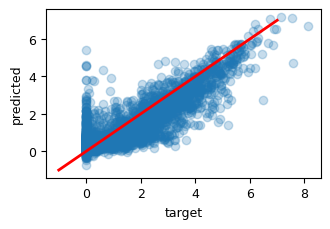

MAE = 0.449


In [6]:
# Plot the predicted vs target values parity plot
import matplotlib.pyplot as plt

plt.scatter(df['True_Label'], df['Prediction'], alpha=0.25)
plt.xlabel('target')
plt.ylabel('predicted')

x = np.linspace(-1, 7, 6)
y = x
plt.plot(x, y, '-r', label='parity')

plt.show()

# pring the mean absolute error
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df['True_Label'], df['Prediction'])
print(f'MAE = {mae:.3f}')

### Using the pretrained model from the installed package

After installing the package, you can perform predictions simply by calling the predict function and specifying the path to the cif files, which should be in the correct format and include the id_prop.csv file.
~~~python
import mlband
df = mlband.model.predict(data_path='/Users/ali/GitHub/rewotes/adavaria/data/mp-test/')
~~~
